In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, expon, poisson, gamma, lognorm

In [9]:
df=pd.read_csv('../data/final_cleaned_drone_dataa.csv')
print(df[:5])

         Date                                     Location Suspected_Target  \
0  2015-01-03                    Spera, Khost, Afghanistan                0   
1  2015-01-06              Dara I Pech, Kunar, Afghanistan                0   
2  2015-01-07                           Logar, Afghanistan                0   
3  2015-01-08  Chikanawr, Lal Pura, Nangarhar, Afghanistan                3   
4  2015-01-11  Chikanawr, Lal Pura, Nangarhar, Afghanistan                3   

  People_Killed Min_Civilians Max_Civilians    Latitude   Longitude  \
0             7             0             0  32.8078448  68.6456967   
1             0             0             0   34.872898   71.155620   
2             3             0             0   34.014551   69.192391   
3             6             0             0   34.354216   70.954680   
4             8             0             0   34.354216   70.954680   

        Country  
0  Afghanistan   
1  Afghanistan   
2  Afghanistan   
3  Afghanistan   
4  Afgha

In [18]:
cols_to_check = ['People_Killed', 'Min_Civilians', 'Max_Civilians']

# Convert to numeric and coerce errors to NaN
for col in cols_to_check:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [19]:
# See rows with bad values if any
print(df[df[cols_to_check].isnull().any(axis=1)])

     Date                Location          Suspected_Target  People_Killed  \
1343  NaN  Most Specific Location  Minimum reported injured            NaN   

      Min_Civilians  Max_Civilians  Latitude  Longitude  Country  
1343            NaN            NaN  Latitude  Longitude  Country  


In [20]:
df = df.dropna(subset=cols_to_check)

In [ ]:

from scipy.stats import norm, expon, poisson, gamma, lognorm

distributions = [norm, expon, poisson, gamma, lognorm]
cols_to_check = ['People_Killed', 'Min_Civilians', 'Max_Civilians']

for col in cols_to_check:
    print(f"\n--- Checking best distribution for: {col} ---")
    
    data = df[col].dropna()
    data = data[data > 0]  # Remove zeros for log-based dists
    
    best_fit = None
    best_p = -1
    best_params = None
    
    for dist in distributions:
        try:
            # Poisson requires discrete data; round floats for it
            if dist == poisson:
                rounded_data = data.round().astype(int)
                params = dist.fit(rounded_data, floc=0)
                ks_stat, p_value = stats.kstest(rounded_data, dist.name, args=params)
            else:
                params = dist.fit(data)
                ks_stat, p_value = stats.kstest(data, dist.name, args=params)
            
            print(f"{dist.name:10s} => KS p-value: {p_value:.5f}")
            
            if p_value > best_p:
                best_p = p_value
                best_fit = dist
                best_params = params
        except Exception as e:
            print(f"{dist.name} failed: {str(e)}")
    
    if best_fit:
        print(f" Best fit for {col}: {best_fit.name.upper()} (p={best_p:.5f})\n")
    else:
        print(f" No suitable distribution found for {col}.\n")




--- Checking best distribution for: People_Killed ---
norm       => KS p-value: 0.00000
expon      => KS p-value: 0.00000
poisson failed: 'poisson_gen' object has no attribute 'fit'
gamma      => KS p-value: 0.00000
lognorm    => KS p-value: 0.00000
✅ Best fit for People_Killed: EXPON (p=0.00000)


--- Checking best distribution for: Min_Civilians ---
norm       => KS p-value: 0.00000
expon      => KS p-value: 0.00001
poisson failed: 'poisson_gen' object has no attribute 'fit'
gamma      => KS p-value: 0.00000
lognorm    => KS p-value: 0.00000
✅ Best fit for Min_Civilians: EXPON (p=0.00001)


--- Checking best distribution for: Max_Civilians ---
norm       => KS p-value: 0.00000
expon      => KS p-value: 0.00001
poisson failed: 'poisson_gen' object has no attribute 'fit'
gamma      => KS p-value: 0.00000
lognorm    => KS p-value: 0.00000
✅ Best fit for Max_Civilians: EXPON (p=0.00001)



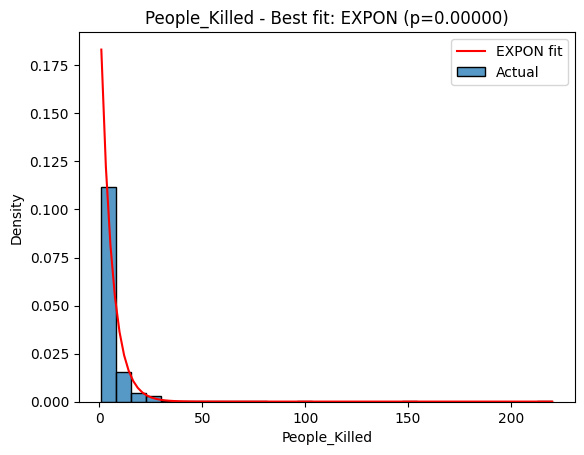

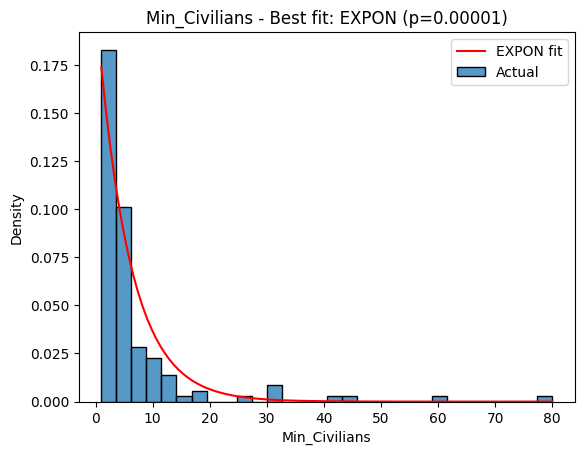

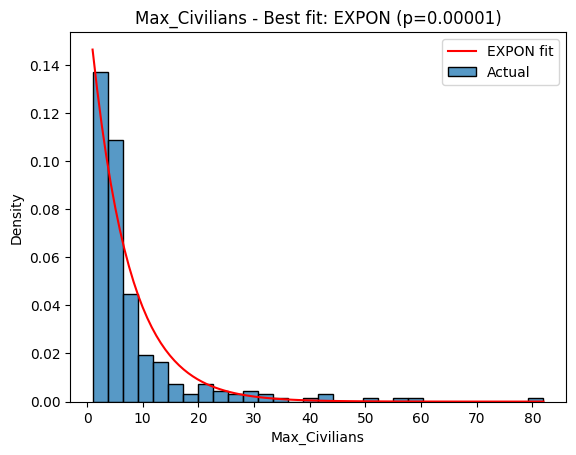

In [22]:
# Visual fit for best distribution
for col in cols_to_check:
    data = df[col]
    data = data[data > 0]

    best_dist = None
    best_p = 0
    best_params = None

    for dist in distributions:
        try:
            params = dist.fit(data)
            ks_stat, p_value = stats.kstest(data, dist.name, args=params)
            if p_value > best_p:
                best_p = p_value
                best_dist = dist
                best_params = params
        except:
            continue

    # Plot actual vs best fit
    sns.histplot(data, kde=False, stat="density", bins=30, label='Actual')
    x = np.linspace(min(data), max(data), 100)
    plt.plot(x, best_dist.pdf(x, *best_params), label=f'{best_dist.name.upper()} fit', color='red')
    plt.title(f'{col} - Best fit: {best_dist.name.upper()} (p={best_p:.5f})')
    plt.legend()
    plt.show()
